### <p align=center> **ML - MACHING LEARNING - RECOMENDATION SYSTEM** <p>

In [267]:
# We import the basic libraries for data and visualization
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

# Surprise library for training
from surprise import Dataset, Reader, SVD

from surprise.model_selection import train_test_split

In [268]:
# Load the scores dataset
df = pd.read_csv("Datasets_Score/df_total_score.csv")

# Load the data set of movies to later extract the title of the movies
df_titulos  = pd.read_csv("df_total_data.csv")

In [269]:
# From the dataset of movies we are only interested in keeping the id and its title

df_titulos = df_titulos[['movieId','title']]

df_titulos = df_titulos.reset_index(drop=True)

df_titulos

,movieId,title
0,as1,the grand seduction
1,as10,david's mother
2,as100,wilder napalm
3,as1000,sinbad: make me wanna holla
4,as1001,simple gifts: the chamber music society at sha...
...,...,...
22993,ns995,this lady called life
22994,ns996,vizontele
22995,ns997,homunculus
22996,ns998,life in color with david attenborough


In [270]:
# Steps prior to making the prediction

N_filas = 100000 # We limit the dataset to N_rows

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']][:N_filas], reader)

# We separate our data

trainset, testset = train_test_split(data, test_size=.25)


In [271]:
# We train the SVD model

model = SVD()

model.fit(trainset)

In [272]:
# We predict

predictions = model.test(testset)

In [273]:
predictions[1]

Prediction(uid=34, iid='ns5110', r_ui=3.5, est=3.1486254973495806, details={'was_impossible': False})

In [274]:
# Make a prediction with random userId and movieId

model.predict(9, 'ns5709')

Prediction(uid=9, iid='ns5709', r_ui=None, est=3.836507838040992, details={'was_impossible': False})

### <p align=center>Complete prediction for a random user <p>

In [275]:
# We will take a random user to make a recommendation

usuario = 63400

score = 3.7 # We take movies that you have rated 4 or 5 stars

df_user = df[(df.userId == usuario) & (df.rating >= score)]

df_user = df_user.reset_index(drop=True)

df_titulos.rename(columns={'id': 'movieId'}, inplace=True)

df_user = pd.merge(df_user, df_titulos[['movieId', 'title']], left_on='movieId', right_on='movieId', how='left')

df_user

,userId,rating,timestamp,movieId,title


In [276]:
recomendaciones_usuario = df_titulos.iloc[:23000].copy()

print(recomendaciones_usuario.shape)

recomendaciones_usuario.head()

(22998, 2)


,movieId,title
0,as1,the grand seduction
1,as10,david's mother
2,as100,wilder napalm
3,as1000,sinbad: make me wanna holla
4,as1001,simple gifts: the chamber music society at sha...


In [277]:
# We must extract the movies that you have already seen

usuario_vistas = df[df['userId'] == usuario]

print(usuario_vistas.shape)

usuario_vistas.head()

(0, 4)


,userId,rating,timestamp,movieId


In [278]:
# We eliminate the movies that the user has already seen

recomendaciones_usuario = recomendaciones_usuario[~recomendaciones_usuario['movieId'].isin(usuario_vistas['movieId'])]

recomendaciones_usuario.shape

(22998, 2)

In [279]:
# We recommend

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['movieId'].apply(lambda x: model.predict(usuario, x).est)

In [280]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)

print(recomendaciones_usuario.head(16))

      movieId                                      title  Estimate_Score
10262   ds228  fantastic four: rise of the silver surfer        4.055998
11996   hs179                               the simpsons        4.053664
19055  ns5377                              chasing coral        4.002417
1120   as2006  jonas kaufmann - a global star in private        3.983495
18913  ns5249                             the lion woman        3.983089
19320  ns5615                      daniel sosa: sosafado        3.982325
8037   as8232                          the wheel of time        3.980468
17069   ns359                                    the net        3.975279
16777  ns3326                                 victorious        3.968930
212     as119             where is chicky? - chapter two        3.963321
18951  ns5283                               carrie pilby        3.944572
3449   as4102                      yuvarathnaa (kannada)        3.943879
3428   as4084            animal songs by little bab

### <p align=center>Prediction entering a user id and a movie id <p>

In [281]:
def get_movie_recommendation(userId, movieId):
    
    # Get the prediction of the rating that the user would give to the movie
    prediction = model.predict(userId, str(movieId))
   
    # If the prediction is greater than or equal to 3.5, the movie is recommended
    if prediction.est >= 3.5:
        return "Recommended", prediction.est
        
    else:
        return "Not recommended", prediction.est

In [282]:
# Example of how get_movie_recommendation works

# user ID
user_id = 27

# movie ID
movie_id = 'as40'

# Get the recommendation for the user and the movie
recommendation = get_movie_recommendation(user_id, movie_id)

# print the recommendation
print("The movie is:", recommendation)

The movie is: ('Not recommended', 3.4594308309654993)


## **Model evaluation** :

In [283]:
# We evaluate the accuracy of the model

from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.9568


0.9567868179272829

### <p align=center>Hyperparameter Optimization <p>

In [284]:
from surprise.model_selection import cross_validate

import numpy as np

rmse_test_means = []

factores = [1,2,4,8,16,32,64,128]

for factor in factores:

    print(factor)

    model = SVD(n_factors=factor)

    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9531  0.9441  0.9485  0.9486  0.0037  
Fit time          1.14    0.90    0.95    0.99    0.10    
Test time         1.81    0.42    0.81    1.01    0.58    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9485  0.9509  0.9473  0.9489  0.0015  
Fit time          1.59    1.52    1.64    1.58    0.05    
Test time         2.32    1.02    0.85    1.40    0.66    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9434  0.9510  0.9530  0.9492  0.0041  
Fit time          1.71    2.37    1.66    1.91    0.33    
Test time         1.25    1.70    1.30    1.41    0.20    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9496  0.9

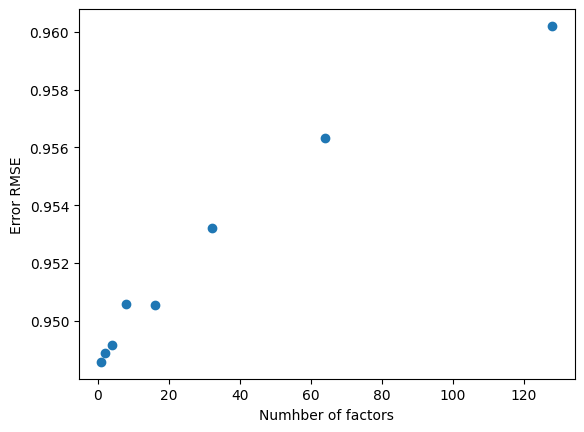

In [285]:
# We plot performance according to number of SVD factors

plt.scatter(factores, rmse_test_means)

plt.xlabel('Numhber of factors')

plt.ylabel('Error RMSE')

plt.show()

### <p align=center> **USER INTERFACE THROUGH GRADIO** <p>

In [286]:
# Import the gradio library to make the interface
import gradio as gr

In [287]:
# We created this function in order to know the title of the movie that we recommend or not

def get_movie_title(movieId):
    
    return df_titulos[df_titulos.movieId == movieId].title.iloc[0].title()

In [288]:
# test the function
get_movie_title('ns400')

'Masters Of The Universe: Revelation'

In [289]:
# We will use the function "get_movie_recommendation" previously declared and the
# newly declared get_movie_title to create a new combined function

def combined_functions(userId, movieId):

    recommended, score = get_movie_recommendation(userId, movieId)

    title = get_movie_title(movieId)
    
    return (recommended, score, title)


In [290]:
combined_functions(32, 'hs40')

('Recommended', 3.9311025011510052, 'Dopesick')

## **Model deploy** :

In [291]:
title = str("Movie recommendation system")

with gr.Blocks(title= title) as demo:

    text = gr.components.HTML("""
    <h1>Welcome to the movie recommendation system!</h1>
    """)

    userId = gr.inputs.Number(label="enter your id")

    movie = gr.Textbox(label="Enter a movie id")

    get_recommendation_btn = gr.Button("Find out if the movie is recommended for you")

    title = gr.Textbox(label = "Name of the movie:")

    output = gr.Textbox(label="Is the movie recommended?")

    score = gr.Textbox(label="Predicted Score:")
    
    get_recommendation_btn.click(fn=combined_functions, inputs=[userId,movie], outputs=[output, score, title])

demo.launch(share=True)


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7871
Running on public URL: https://3887f48b20377313eb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
